In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime
import os
from sklearn.metrics import roc_auc_score

In [253]:
#https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [254]:
#input variables
path = 'image_arrays'

#model variables
test_train_split = 0.75
batch_size = 128
epoch_number = 100
validation_split = 0.15
learning_rate = 5e-7
dropout_rate = 0.50

#architecture variables
CNL1_filters = 32
CNL1_kernal_size = 5
MPL1_pool_size= (2,2)
MPL1_strides = 2
CNL2_filters = 64
CNL2_kernal_size = 5
MPL2_pool_size = (2,2)
MPL2_strides = 2

In [255]:
galaxyzoo = pd.read_csv("zoo2MainSpecz.csv", usecols=[8], nrows=10000)
Class = galaxyzoo["gz2class"].values
dictionary = {'A':int(2),'E':int(1),'S':int(0)}
#resave using my dictionary
target = np.empty((len(Class)))
for i in range(len(Class)):
    target[i] = int(dictionary[Class[i][0]])

In [256]:
#https://keras.io/preprocessing/image/

#datagen flow from directory wont work, need to create a different iterator. Have to combine with the targets somehow. 

#seems like a tf.data.Dataset is what we want... well, in the future atleast. lets right now get this working by doing something
#memory intensive.
#def generator(path,batchsize):
#    """
#    I want this function when called provide a 
#    """
#    image_list = os.listdir(path)
    

In [257]:
directory = os.listdir(path)
data = np.zeros((len(directory),64,64,5))
inbetween_target = np.zeros((len(directory)))
for i in range(len(directory)):
    ith = directory[i].split('_')[-1]
    ith = ith.split('.')[0] #we want the str of what element this is so I can grab from my target array the correct label
    ith = int(ith)
    array = np.load('{}\\{}'.format(path,directory[i]))
    data[i,:,:,:] = array
    inbetween_target[i] = target[ith]
target = inbetween_target
print(len(target))
print(np.shape(data))
print(len(directory))

7848
(7848, 64, 64, 5)
7848


In [258]:
tts_index = int(np.round(test_train_split * len(directory),0))
train_target = target[0:tts_index]
test_target = target[tts_index::]
train_images = data[0:tts_index]
test_images = data[tts_index::]

In [259]:
def create_model(dropout_rate=dropout_rate, learning_rate=learning_rate):
    
    model = keras.Sequential([])
    model.add(keras.layers.Conv2D(input_shape=(64,64,5),filters=CNL1_filters,kernel_size=CNL1_kernal_size,padding="same",activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=MPL1_pool_size, strides=MPL1_strides))
    model.add(keras.layers.Conv2D(filters=CNL2_filters,kernel_size=CNL2_kernal_size,padding="same",activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(pool_size=MPL2_pool_size,strides=MPL2_strides))
    model.add(keras.layers.Reshape([16*16*64]))
    model.add(keras.layers.Dense(units=1024,activation=tf.nn.relu))
    model.add(keras.layers.Dense(units=512,activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=dropout_rate))
    model.add(keras.layers.Dense(units=3,activation=tf.nn.softmax))
    adam = keras.optimizers.Adam(lr = learning_rate)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',metrics=['accuracy',]) #auroc])
    return(model)

In [260]:
#datagenerator will rotate flip and zoom my data for augmentations, b/c of cosmo principle I must be invarient to these.

#interestingly enough, there is no support for datagen right now with 5 channels:
#https://github.com/keras-team/keras/issues/4664
#that sucks, because if memory was an issue before, now I will have to default on doing my image roatations and zooms before
#hand, and that also takes up memory.

In [261]:
#so this is pretty neat, you can create a keras callback to display on tensorboard using a simplified summary tf api

#and also this is an example of how to change the lr on the fly, which is pretty handy
#https://keras.io/callbacks/

logdir="summaries/scalars/" + str(datetime.datetime.now().timestamp())
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                   histogram_freq=1,
                                                   write_graph=False,
                                                   write_grads=True,)
                                                   #write_images=True)
"""
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

def lr_schedule(epoch):
"""
#Returns a custom learning rate that decreases as epochs progress.
"""
    learning_rate = 0.2
    if epoch > 10:
        learning_rate = 0.02
    if epoch > 20:
        learning_rate = 0.01
    if epoch > 50:
        learning_rate = 0.005

    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
"""


"\n    learning_rate = 0.2\n    if epoch > 10:\n        learning_rate = 0.02\n    if epoch > 20:\n        learning_rate = 0.01\n    if epoch > 50:\n        learning_rate = 0.005\n\n    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)\n    return learning_rate\n\nlr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)\ntensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)\n"

In [262]:
keras.backend.clear_session()
model = create_model(dropout_rate=dropout_rate, learning_rate = learning_rate)

In [263]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        4032      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              16778240  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
__________

In [264]:
history = model.fit(train_images,
                    train_target,
                    batch_size=batch_size,
                    epochs=epoch_number,
                    validation_split=validation_split,
                    callbacks=[tensorboard_callback])#, lr_callback]) #and will display that on tensorboard too

Train on 5003 samples, validate on 883 samples
Epoch 1/100
5003/5003 [==============================] - 66s 13ms/sample - loss: 1.1716 - acc: 0.4253 - val_loss: 1.1009 - val_acc: 0.3941
Epoch 2/100
5003/5003 [==============================] - 55s 11ms/sample - loss: 1.1619 - acc: 0.4261 - val_loss: 1.0880 - val_acc: 0.4077
Epoch 3/100
5003/5003 [==============================] - 56s 11ms/sample - loss: 1.1444 - acc: 0.4491 - val_loss: 1.0762 - val_acc: 0.4156
Epoch 4/100
5003/5003 [==============================] - 54s 11ms/sample - loss: 1.1242 - acc: 0.4485 - val_loss: 1.0652 - val_acc: 0.4258
Epoch 5/100
5003/5003 [==============================] - 52s 10ms/sample - loss: 1.1114 - acc: 0.4629 - val_loss: 1.0548 - val_acc: 0.4337
Epoch 6/100
5003/5003 [==============================] - 66s 13ms/sample - loss: 1.1185 - acc: 0.4655 - val_loss: 1.0448 - val_acc: 0.4383
Epoch 7/100
5003/5003 [==============================] - 51s 10ms/sample - loss: 1.0848 - acc: 0.4805 - val_loss: 1.035

5003/5003 [==============================] - 51s 10ms/sample - loss: 0.8591 - acc: 0.5872 - val_loss: 0.8452 - val_acc: 0.6116
Epoch 60/100
5003/5003 [==============================] - 51s 10ms/sample - loss: 0.8608 - acc: 0.5902 - val_loss: 0.8436 - val_acc: 0.6116
Epoch 61/100
5003/5003 [==============================] - 64s 13ms/sample - loss: 0.8604 - acc: 0.5898 - val_loss: 0.8420 - val_acc: 0.6138
Epoch 62/100
5003/5003 [==============================] - 51s 10ms/sample - loss: 0.8803 - acc: 0.5741 - val_loss: 0.8405 - val_acc: 0.6149
Epoch 63/100
5003/5003 [==============================] - 51s 10ms/sample - loss: 0.8620 - acc: 0.5787 - val_loss: 0.8389 - val_acc: 0.6161
Epoch 64/100
5003/5003 [==============================] - 52s 10ms/sample - loss: 0.8600 - acc: 0.5942 - val_loss: 0.8375 - val_acc: 0.6161
Epoch 65/100
5003/5003 [==============================] - 53s 11ms/sample - loss: 0.8674 - acc: 0.5876 - val_loss: 0.8358 - val_acc: 0.6138
Epoch 66/100
5003/5003 [=========

In [265]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

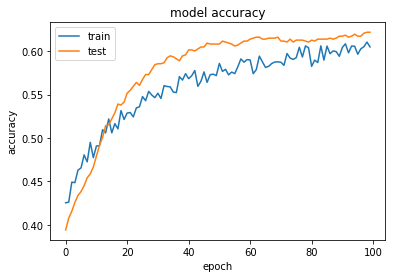

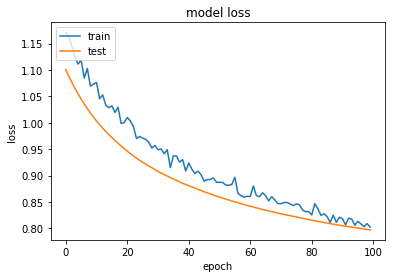

In [266]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy-2.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss-2.png')
plt.show()

In [267]:
test_loss, test_acc = model.evaluate(test_images, test_target)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

1962/1962 [==============================] - 7s 4ms/sample - loss: 0.8143 - acc: 0.5892
Test accuracy: 0.5891947
Test loss: 0.814308757142797


In [268]:
"""
model_1

test_train_split = 0.75
batch_size = 64
epoch_number = 20
validation_split = 0.15
learning_rate = 1e-3
dropout_rate = 0.40

output: terrible overtraining, but promising that in 20 epochs I hit 92%: reducing learning rate by a lot
"""

""""
model_2

test_train_split = 0.75
batch_size = 64
epoch_number = 20
validation_split = 0.15
learning_rate = 1e-6
dropout_rate = 0.40


Test accuracy: 0.60142714
Test loss: 0.7398002415622046

Epoch 20/20
5003/5003 [==============================] - 59s 12ms/sample - loss: 0.6610 - acc: 0.6874 - val_loss: 0.7216 - val_acc: 0.6625

Perhaps I was a little overzealous with the LR reduction: I am going to prop it back up, increase dropout.
"""

"""
model_3

test_train_split = 0.75
batch_size = 64
epoch_number = 20
validation_split = 0.15
learning_rate = 1e-4
dropout_rate = 0.45

1962/1962 [==============================] - 7s 4ms/sample - loss: 0.9262 - acc: 0.7457
Test accuracy: 0.7456677
Test loss: 0.9262316330249643

Epoch 19/20
5003/5003 [==============================] - 58s 12ms/sample - loss: 0.1947 - acc: 0.9310 - val_loss: 0.8856 - val_acc: 0.7610
Epoch 20/20
5003/5003 [==============================] - 58s 12ms/sample - loss: 0.1838 - acc: 0.9414 - val_loss: 0.9662 - val_acc: 0.7542

too high of LR: trying to lower by 1e-1
"""

"""
model_4

#model variables
test_train_split = 0.75
batch_size = 64
epoch_number = 20
validation_split = 0.15
learning_rate = 1e-5
dropout_rate = 0.45

Epoch 19/20
5003/5003 [==============================] - 60s 12ms/sample - loss: 0.4295 - acc: 0.8183 - val_loss: 0.6812 - val_acc: 0.7407
Epoch 20/20
5003/5003 [==============================] - 60s 12ms/sample - loss: 0.4200 - acc: 0.8279 - val_loss: 0.6655 - val_acc: 0.7293

1962/1962 [==============================] - 7s 4ms/sample - loss: 0.6960 - acc: 0.6774
Test accuracy: 0.67737
Test loss: 0.6960039274286665

very weird that this has a lower accuracy, but also much lower loss than model_3, which clearly had too high a LR
:Increasing LR slightly, just to see where I can maximize it and still be stable.
"""

"""
model_5

test_train_split = 0.75
batch_size = 64
epoch_number = 20
validation_split = 0.15
learning_rate = 3e-5
dropout_rate = 0.45

Epoch 19/20
5003/5003 [==============================] - 60s 12ms/sample - loss: 0.3353 - acc: 0.8701 - val_loss: 0.7270 - val_acc: 0.7316
Epoch 20/20
5003/5003 [==============================] - 60s 12ms/sample - loss: 0.3200 - acc: 0.8811 - val_loss: 0.7252 - val_acc: 0.7395

1962/1962 [==============================] - 7s 4ms/sample - loss: 0.7473 - acc: 0.7125
Test accuracy: 0.71253824
Test loss: 0.747275456770966

#I liked it better at lower, and then add more epochs, increase dropout because overfitting is a thing.

I forgot to download the graph outputs, but it was basically a straight lines after ~3 epochs along 0.72 accuracy and 0.86 loss
"""

"""
model_6

test_train_split = 0.75
batch_size = 64
epoch_number = 50
validation_split = 0.15
learning_rate = 1e-6
dropout_rate = 0.50

Epoch 49/50
5003/5003 [==============================] - 59s 12ms/sample - loss: 0.5778 - acc: 0.7256 - val_loss: 0.6859 - val_acc: 0.6840
Epoch 50/50
5003/5003 [==============================] - 60s 12ms/sample - loss: 0.5838 - acc: 0.7234 - val_loss: 0.6876 - val_acc: 0.6795


1962/1962 [==============================] - 7s 4ms/sample - loss: 0.7073 - acc: 0.6213
Test accuracy: 0.6213048
Test loss: 0.7072517683503582
"""

"""
model_7 

test_train_split = 0.75
batch_size = 64
epoch_number = 50
validation_split = 0.15
learning_rate = 3e-6
dropout_rate = 0.50

implemented tensorboard during this guy, so can go there to see the runs data and graphs. I think on this next one I want to
build a different architecture. There was that paper Gautham posted from 2018 and it woould be neat to use their working arch.
But since it is lunch time, I will make a fwe small changed and hit go. I am mainly testing some more tensorboard features on
this model. but also, fuck it, I added another dense layer just for shits and giggles.

I'm pretty sure since I can get my training accuracy well over 90% (perhaps by overtraining?) that this is unneccessary
because this high accuracy means that I am fully able to map the training space. But also-- what the fuck do I know lol?

I also increased batchsize apparently.

also, auroc isnt working, something abput py.func being deprecated in tf2.0; look that guy up the error said it was a simple
fix
"""

"\nmodel_7 \n\ntest_train_split = 0.75\nbatch_size = 64\nepoch_number = 50\nvalidation_split = 0.15\nlearning_rate = 3e-6\ndropout_rate = 0.50\n\nimplemented tensorboard during this guy, so can go there to see the runs data and graphs. I think on this next one I want to\nbuild a different architecture. There was that paper Gautham posted from 2018 and it woould be neat to use their working arch.\nBut since it is lunch time, I will make a fwe small changed and hit go. I am mainly testing some more tensorboard features on\nthis model. but also, fuck it, I added another dense layer just for shits and giggles.\n\nI'm pretty sure since I can get my training accuracy well over 90% (perhaps by overtraining?) that this is unneccessary\nbecause this high accuracy means that I am fully able to map the training space. But also-- what the fuck do I know lol?\n\nI also increased batchsize apparently.\n\nalso, auroc isnt working, something abput py.func being deprecated in tf2.0; look that guy up th

In [269]:
#source list
"""
https://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/

https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

https://astrobites.org/2018/07/16/creating-a-more-general-deep-learning-algorithm-for-galaxies/
"""

'\nhttps://fizzylogic.nl/2017/05/08/monitor-progress-of-your-keras-based-neural-network-using-tensorboard/\n\nhttps://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras\n\nhttps://astrobites.org/2018/07/16/creating-a-more-general-deep-learning-algorithm-for-galaxies/\n'